# Installing and importing dependencies 📚

In [1]:
!pip install ultralytics
!pip install -U ipywidgets
!pip install ffmpeg-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.1/715.1 kB 19.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 58.8 MB/s eta 0:00:00:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [2]:
from ultralytics import YOLO
import glob
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import math
import yaml
import torch
import cv2
import random
from IPython.display import HTML, display, Image
from base64 import b64encode

In [3]:
np.random.seed(12345)

In [4]:
!wandb disabled

W&B disabled.


In [5]:
dataset_root = '/kaggle/input/construction-site-safety-image-dataset-roboflow/css-data'

# EDA 📊

<span style="font-size:18px;"> In this section we will explore that dataset, performing EDA (Exploratory Data Analysis).

In [6]:
class_map = {0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'}
classes = ['Hardhat', 'Mask', 'NO-Hardhat', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']

In [7]:
for subset_folder in ['train', 'valid', 'test']:
    subset_images = glob.glob(os.path.join(dataset_root, subset_folder, 'images','*.jpg'))
    print(f"Number of {subset_folder} images:", len(subset_images))

Number of train images: 2605
Number of valid images: 114
Number of test images: 82


<span style="font-size:18px;"> Let's visualize a few images from the training set.

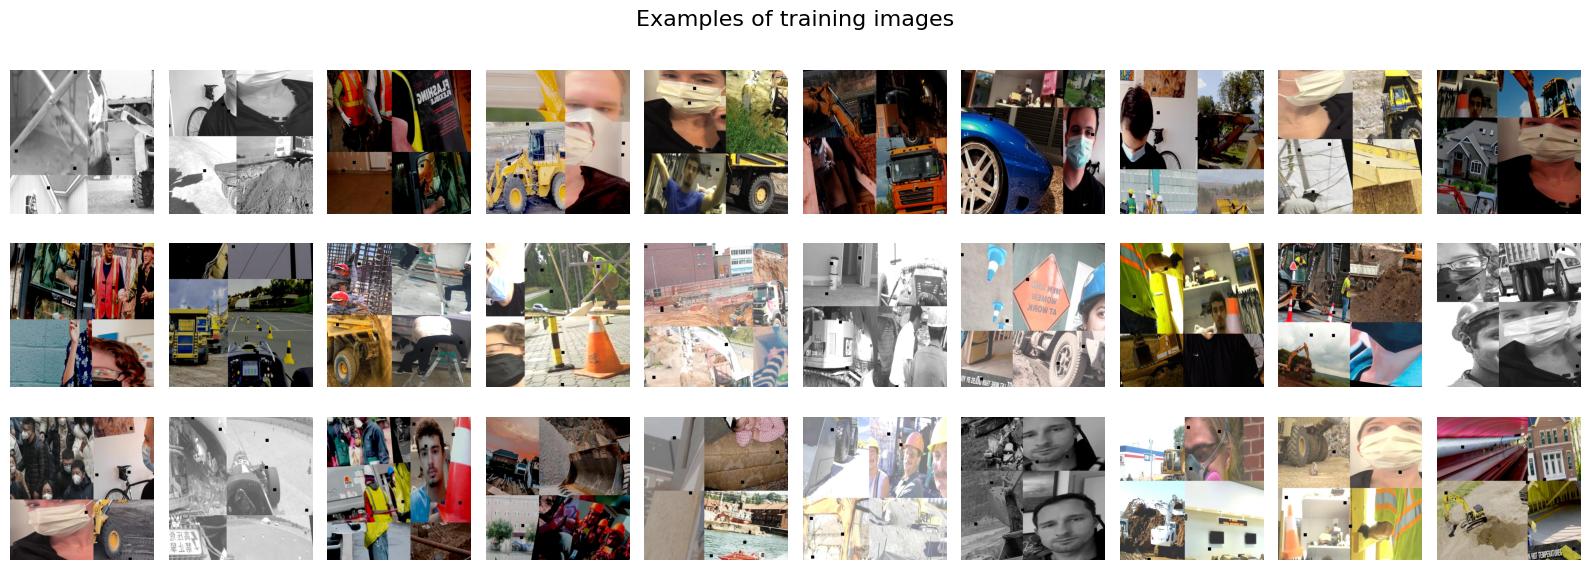

In [8]:
test_imgs_with_pred = glob.glob(os.path.join(dataset_root, 'train', 'images','*.jpg'))

fig, axes = plt.subplots(3, 10, figsize=(16,6))
fig.suptitle('Examples of training images', fontsize=16)


# Randomly select 15 images
selected_images = random.sample(test_imgs_with_pred, 30)

for i, ax in enumerate(axes.flatten()):
    image = cv2.imread(selected_images[i])
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ax.imshow(image)
    ax.axis("off")

plt.tight_layout()
plt.show()

<span style="font-size:18px;">  We can notice that there are some tiny black rectangles on most of the training images and this is because one of the augmentation techniques used for this dataset is random crop between 0 and 20% for each image. 

In [9]:
classes_dict = {}
for subset_folder in ['train', 'valid', 'test']:
    label_folder = glob.glob(os.path.join(dataset_root, subset_folder, 'labels','*.txt'))
    cl = []
    for anno_file in label_folder:
        with open(anno_file) as f:
            lines = [line.strip() for line in open(anno_file, 'r')]
            cl.extend([line[0][0] for line in lines])
    cl_count = {c: cl.count(c) for c in cl}
    classes_dict[subset_folder] = cl_count


## Bar charts

<span style="font-size:18px;">  Every bar chart represents the number of instances for each class within the train, validation and test sets. We can see that 'Person' class is the major class, and 'Mask' class is the minority class with the fewest instances in all sets. <span>

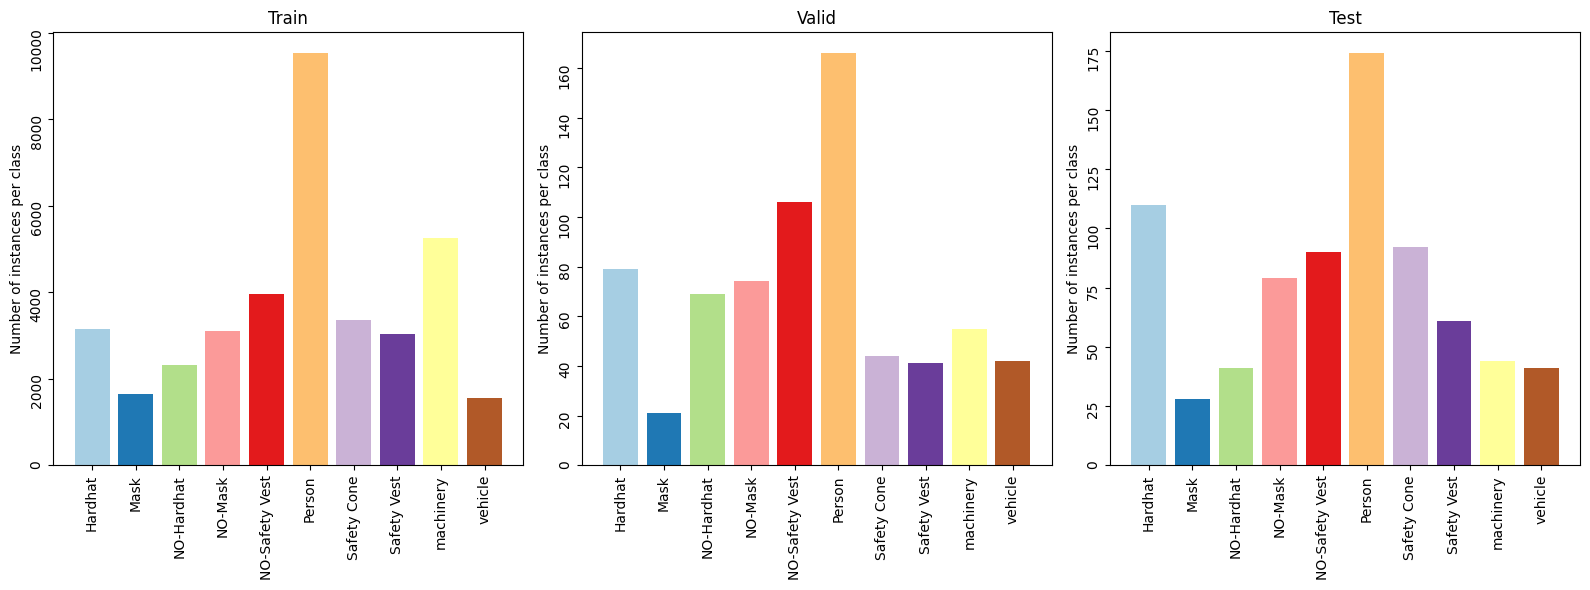

In [10]:
fig, axes = plt.subplots(1, len(classes_dict), figsize=(16, 6))

# Create a colormap
cmap = plt.get_cmap('Paired')

# Generate colors based on the colormap for each class
colors = cmap(np.linspace(0, 1, len(classes)))

for i, (class_name, attributes) in enumerate(classes_dict.items()):
    sorted_attribute_names = sorted(list(attributes.keys()))
    sorted_measurments = [attributes[c] for c in sorted_attribute_names]
    x = np.arange(len(sorted_attribute_names))
    
    axes[i].bar(x, sorted_measurments, tick_label=[class_map[int(item)] for item in sorted_attribute_names], color=colors)
    axes[i].tick_params(rotation=90)
    axes[i].set_title(f'{class_name.capitalize()}')
    axes[i].set_ylabel('Number of instances per class')

plt.tight_layout()
plt.show()

## Pie charts 

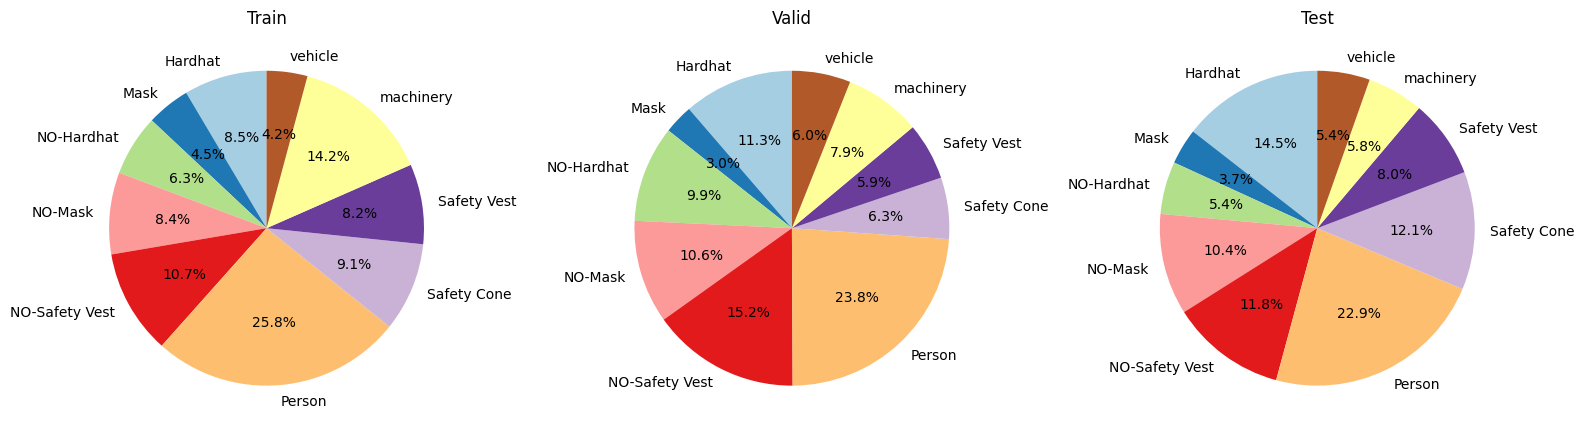

In [11]:
fig, axes = plt.subplots(1, len(classes_dict), figsize=(16, 6))

# Generate colors based on the colormap
colors = cmap(np.linspace(0, 1, len(classes)))

for i, (class_name, attributes) in enumerate(classes_dict.items()):
    sorted_attribute_names = sorted(list(attributes.keys()))
    sorted_measurments = [attributes[c] for c in sorted_attribute_names]

    axes[i].pie(sorted_measurments, labels=[class_map[int(item)] for item in sorted_attribute_names], autopct='%1.1f%%', startangle=90, colors=colors)
    axes[i].set_title(f'{class_name.capitalize()}')

plt.tight_layout()
plt.show()

# Model training (Yolov8) ⏳

<span style="font-size:18px;"> For this project, we will use Yolov8, nano version, from Ultralytics. The model is trained for 40 epochs and batch size 32. </span>

In [12]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.23M/6.23M [00:00<00:00, 114MB/s]


<span style="font-size:18px;"> In order to train the Yolov8 model we need a dataset yaml. config file that defines the dataset root directory path, the paths to train / val / test image directories and dictionary containing the dataset class names.

In [13]:
yolo_yaml = {'path': dataset_root,
             'train': os.path.join(dataset_root, 'train/images'),  
             'val': os.path.join(dataset_root, 'valid/images'),
             'test': os.path.join(dataset_root, 'test/images'), 

            # Classes 
            'names' : {
              0: 'Hardhat',
              1: 'Mask',
              2: 'NO-Hardhat',
              3: 'NO-Mask',
              4: 'NO-Safety Vest',
              5: 'Person',
              6: 'Safety Cone',
              7: 'Safety Vest',
              8: 'machinery',
              9: 'vehicle'}
            }
            

with open(os.path.join('/kaggle/working/', 'data.yaml'), 'w+') as file:
    yaml.dump(yolo_yaml, file)

In [14]:
model.train(data='/kaggle/working/data.yaml', epochs=40, batch=32, imgsz=640, name='Initial training with yolov8')

Ultralytics YOLOv8.1.15 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=40, time=None, patience=50, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=Initial training with yolov8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=

100%|██████████| 755k/755k [00:00<00:00, 22.0MB/s]
2024-02-18 04:54:10.882203: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-18 04:54:10.882338: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-18 04:54:11.001923: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

train: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/labels... 2605 images, 6 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:05<00:00, 449.67it/s]

train: WARNING ⚠️ /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train/images/construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


train: WARNING ⚠️ Cache directory /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/train is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid/labels... 114 images, 10 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<00:00, 454.99it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/valid is not writeable, cache not saved.


Plotting labels to runs/detect/Initial training with yolov8/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/Initial training with yolov8
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      6.98G      1.398          3      1.495        308        640: 100%|██████████| 82/82 [00:35<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.39s/it]

                   all        114        697      0.434      0.332      0.317      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      6.67G      1.288      1.857       1.44        318        640: 100%|██████████| 82/82 [00:29<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all        114        697      0.608      0.466       0.48      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      6.39G      1.248      1.661       1.41        198        640: 100%|██████████| 82/82 [00:29<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all        114        697      0.674      0.363      0.447      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      6.27G      1.214      1.566       1.38        290        640: 100%|██████████| 82/82 [00:29<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]

                   all        114        697      0.603      0.472      0.481      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      5.29G      1.192      1.464      1.353        276        640: 100%|██████████| 82/82 [00:29<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all        114        697       0.67      0.497       0.53      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      6.88G      1.164      1.389      1.333        305        640: 100%|██████████| 82/82 [00:28<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all        114        697      0.637      0.473      0.513      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      5.18G      1.157      1.362      1.327        213        640: 100%|██████████| 82/82 [00:29<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all        114        697      0.692      0.494      0.558      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      6.28G      1.127      1.313      1.304        210        640: 100%|██████████| 82/82 [00:29<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all        114        697      0.685       0.54      0.567      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      5.68G      1.123      1.265      1.288        278        640: 100%|██████████| 82/82 [00:29<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all        114        697      0.728      0.536      0.597      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      6.32G      1.098      1.226      1.281        253        640: 100%|██████████| 82/82 [00:29<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all        114        697      0.688      0.581      0.614      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      5.57G      1.099      1.203      1.277        195        640: 100%|██████████| 82/82 [00:29<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all        114        697       0.78      0.567      0.647      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      5.48G      1.076      1.164      1.262        315        640: 100%|██████████| 82/82 [00:29<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all        114        697      0.801      0.563      0.648      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      6.29G      1.067      1.131      1.248        311        640: 100%|██████████| 82/82 [00:29<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all        114        697      0.806      0.592      0.667       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      6.06G      1.068      1.116      1.242        353        640: 100%|██████████| 82/82 [00:29<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all        114        697      0.822      0.575      0.664      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      6.16G      1.041      1.098       1.24        220        640: 100%|██████████| 82/82 [00:29<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all        114        697      0.798      0.573       0.67      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      6.65G      1.052      1.082      1.241        285        640: 100%|██████████| 82/82 [00:29<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all        114        697      0.811      0.594      0.661      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      5.97G       1.03      1.045      1.228        291        640: 100%|██████████| 82/82 [00:29<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all        114        697      0.835      0.594      0.672      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      5.91G      1.019      1.031      1.223        349        640: 100%|██████████| 82/82 [00:29<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all        114        697      0.852      0.622      0.684      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      5.78G      1.014      1.018      1.219        276        640: 100%|██████████| 82/82 [00:29<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all        114        697      0.792      0.642      0.702      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      5.38G      1.005     0.9985      1.202        324        640: 100%|██████████| 82/82 [00:29<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all        114        697      0.802      0.643      0.714       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      6.56G     0.9974     0.9792      1.198        275        640: 100%|██████████| 82/82 [00:29<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all        114        697      0.815      0.608      0.686      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      5.93G     0.9827     0.9598      1.192        237        640: 100%|██████████| 82/82 [00:29<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all        114        697      0.846      0.607      0.707      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      6.45G     0.9739      0.951      1.189        239        640: 100%|██████████| 82/82 [00:29<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all        114        697      0.863       0.64      0.719      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      6.16G     0.9785     0.9438      1.183        403        640: 100%|██████████| 82/82 [00:29<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all        114        697      0.885      0.624      0.724      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      6.12G     0.9527     0.9236       1.18        359        640: 100%|██████████| 82/82 [00:29<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all        114        697      0.885      0.629       0.73      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      5.32G     0.9537     0.9026       1.17        257        640: 100%|██████████| 82/82 [00:30<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all        114        697       0.86      0.637      0.723      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40       7.1G      0.956     0.9003       1.17        295        640: 100%|██████████| 82/82 [00:29<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all        114        697      0.843       0.65       0.74      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40       7.5G     0.9362     0.8766       1.16        262        640: 100%|██████████| 82/82 [00:29<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all        114        697      0.843      0.677      0.742      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      6.95G     0.9259     0.8652      1.154        305        640: 100%|██████████| 82/82 [00:30<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all        114        697      0.877      0.671      0.752      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      6.12G     0.9248     0.8543      1.155        394        640: 100%|██████████| 82/82 [00:29<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all        114        697      0.895      0.657      0.746      0.425


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      6.51G      0.958      0.808      1.174        168        640: 100%|██████████| 82/82 [00:33<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all        114        697      0.852      0.664      0.741      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40       5.4G     0.9238     0.7617      1.154        140        640: 100%|██████████| 82/82 [00:27<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all        114        697      0.836      0.676      0.757      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      5.38G     0.9126     0.7404      1.145        171        640: 100%|██████████| 82/82 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all        114        697       0.88       0.67      0.758      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      5.11G     0.9035     0.7268      1.137        181        640: 100%|██████████| 82/82 [00:27<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all        114        697      0.851      0.684      0.755      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      5.22G     0.8963     0.7209      1.134        120        640: 100%|██████████| 82/82 [00:27<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all        114        697      0.872      0.701      0.765      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      4.83G     0.8899     0.7134      1.128        201        640: 100%|██████████| 82/82 [00:27<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all        114        697      0.856      0.693      0.763      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      5.38G     0.8757     0.7007       1.12        152        640: 100%|██████████| 82/82 [00:27<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all        114        697      0.894      0.683      0.768       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      5.47G     0.8674     0.6945      1.119        156        640: 100%|██████████| 82/82 [00:27<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all        114        697      0.896      0.684      0.774      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      4.76G     0.8579     0.6815       1.11        180        640: 100%|██████████| 82/82 [00:27<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all        114        697      0.894      0.685      0.773      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      5.17G     0.8491     0.6709       1.11        132        640: 100%|██████████| 82/82 [00:27<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all        114        697      0.882      0.695      0.774      0.462



40 epochs completed in 0.358 hours.
Optimizer stripped from runs/detect/Initial training with yolov8/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/Initial training with yolov8/weights/best.pt, 6.3MB

Validating runs/detect/Initial training with yolov8/weights/best.pt...
Ultralytics YOLOv8.1.15 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16276MiB)
Model summary (fused): 168 layers, 3007598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]


                   all        114        697      0.882      0.694      0.774      0.462
               Hardhat        114         79      0.971      0.709       0.87      0.571
                  Mask        114         21      0.912       0.81      0.838      0.592
            NO-Hardhat        114         69      0.902      0.535      0.687       0.34
               NO-Mask        114         74      0.883       0.51      0.601      0.281
        NO-Safety Vest        114        106      0.879      0.651      0.744      0.429
                Person        114        166      0.894       0.71      0.812        0.5
           Safety Cone        114         44      0.846      0.841      0.863      0.429
           Safety Vest        114         41      0.923      0.805      0.886      0.556
             machinery        114         55      0.924      0.873      0.925      0.607
               vehicle        114         42      0.683        0.5       0.51      0.315
Speed: 0.2ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7884a2b4dbd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

<span style="font-size:18px;">  Let's visualize the results on the training as well as the validation datasets.

<span style="font-size:18px;"> Looking at the plots, we can observe that the loss is steadily decreasing, while the metrics are increasing. We could further enhance the model's performance by training for more epochs or using a larger version of the Yolo model. Nevertheless, the current results already appear quite satisfactory for the purpose of this notebook.

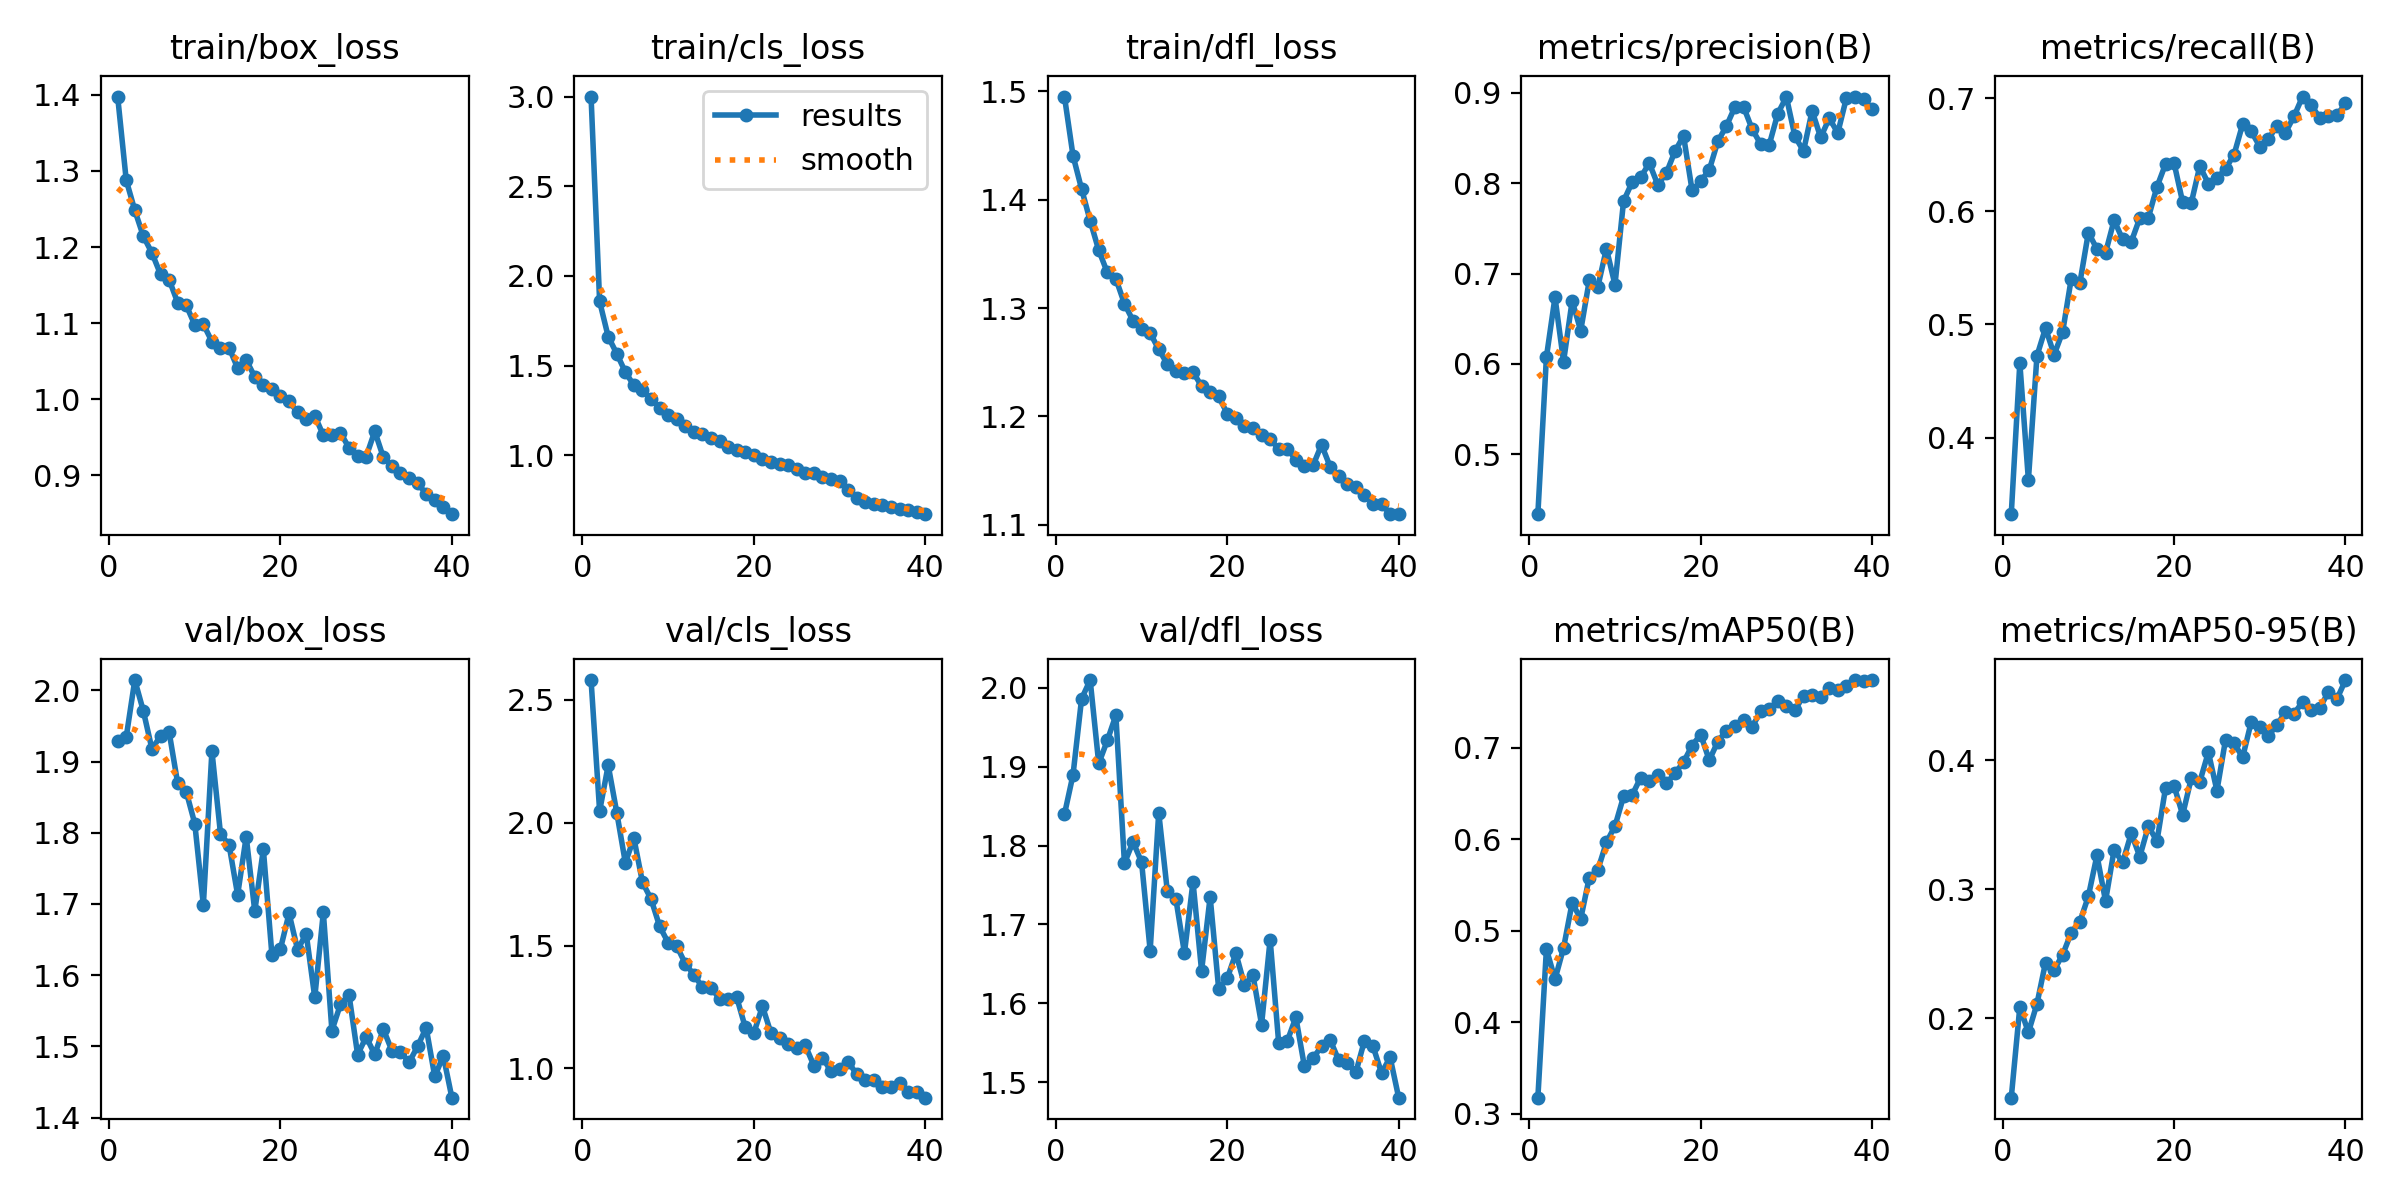

In [37]:
Image(filename=f'/kaggle/working/runs/detect/Initial training with yolov8/results.png', width=900)

# Inference on test data 😎

<span style="font-size:18px;">  Now it is time to run inference on test images. We will pick randomly 15 images from the test dataset and visualize them to evaluate the results.

In [38]:
trained_detection_model = YOLO('/kaggle/working/runs/detect/Initial training with yolov8/weights/best.pt')

In [39]:
detection_results = trained_detection_model.predict(source=os.path.join(dataset_root, 'test/images'), save=True)


image 1/82 /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images/-4405-_png_jpg.rf.82b5c10b2acd1cfaa24259ada8e599fe.jpg: 640x640 1 Hardhat, 1 NO-Safety Vest, 1 Person, 6.1ms
image 2/82 /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images/000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg: 640x640 3 Hardhats, 2 NO-Masks, 5 Persons, 6.4ms
image 3/82 /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images/002551_jpg.rf.ce4b9f934161faa72c80dc6898d37b2d.jpg: 640x640 2 Hardhats, 1 NO-Mask, 2 NO-Safety Vests, 3 Persons, 6.5ms
image 4/82 /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images/003357_jpg.rf.9867f91e88089bb68dc95947d5116d14.jpg: 640x640 1 Hardhat, 1 NO-Mask, 1 NO-Safety Vest, 1 Person, 1 Safety Cone, 6.7ms
image 5/82 /kaggle/input/construction-site-safety-image-dataset-roboflow/css-data/test/images/004063_jpg.rf.1b7cdc4035bcb24ef69b8798b444053e.jpg: 640x640 6 Hardhat

In [62]:
import csv

# Sample data
model_output =detection_results

# Define the class labels
class_labels = ['Safety helmet', 'Mask', 'Without safety helmet', 'Without mask', 'Without safety vest', 'Person', 'Safety cone', 'Safety vest', 'Machinery', 'Vehicle']

# Extracting information and saving to CSV
output_file = "model_output.csv"
with open(output_file, mode='w', newline='') as csv_file:
    fieldnames = ["filename"] + class_labels
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    
    writer.writeheader()
    for line in model_output:
        # Extract information from the line (you might need to customize this part based on the actual output format)
        image_info = line.split(' ')
        image_name = image_info[82]
        classes_present = image_info[6:-1]
        
        # Initialize row dictionary with zeros
        row_dict = {"filename": image_name}
        row_dict.update({class_label: 0 for class_label in class_labels})
        
        # Set 1 for classes present in the image
        for class_present in classes_present:
            class_label = class_present.strip(',')
            if class_label in class_labels:
                row_dict[class_label] = 1
        
        # Write to CSV
        writer.writerow(row_dict)

print(f"Model output saved to {output_file}")


IndexError: list index out of range

In [44]:
import os
import csv

def convert_to_csv(input_path, output_path):
    """Converts saved results in a directory to a CSV file with specified columns.

    Args:
        input_path (str): Path to the directory containing the saved results (txt files).
        output_path (str): Path to the output CSV file.
    """

    column_names = ['filename', 'Safety helmet', 'Mask', 'Without safety helmet',
                    'Without mask', 'Without safety vest', 'Person', 'Safety cone',
                    'Safety vest', 'Machinery', 'Vehicle']

    with open(output_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=column_names)
        writer.writeheader()

        for filename in os.listdir(input_path):
            if filename.endswith('.txt'):
                filepath = os.path.join(input_path, filename)
                with open(filepath, 'r') as infile:
                    lines = infile.readlines()

                    # Process each line, handle potential errors, and extract necessary information
                    for line in lines:
                        try:
                            # Handle cases where the line might not contain the expected format
                            if "image" not in line or ":" not in line:
                                continue

                            image_path, _ = line.split(':')
                            image_info = line.split()[2:]

                            # Create a dictionary mapping class names to 1/0 based on their presence
                            class_dict = {name: 0 for name in column_names[1:]}
                            for info in image_info:
                                class_name, _ = info.split(',')
                                class_dict[class_name] = 1

                            # Handle potential missing columns without raising errors
                            data = {
                                'filename': image_path,
                                **class_dict,
                            }
                            writer.writerow(data)
                        except Exception as e:
                            print(f"Error processing line: {line}\n{e}")

if __name__ == '__main__':
    input_path = "runs/detect/predict"  # Replace with your actual path
    output_path = "results.csv"  # Replace with your desired output file name
    convert_to_csv(input_path, output_path)


In [59]:
import os
import pandas as pd

# Chemin du répertoire contenant les fichiers CSV
directory_path = "runs/detect/predict2"

# Listez tous les fichiers dans le répertoire
files = os.listdir(directory_path)

# Filtrez les fichiers pour inclure uniquement les fichiers CSV
csv_files = [file for file in files if file.endswith('.csv')]

# Vérifiez s'il y a au moins un fichier CSV
if csv_files:
    # Prenez le premier fichier CSV trouvé
    csv_path = os.path.join(directory_path, csv_files[0])

    # Charger le fichier CSV dans un DataFrame
    df = pd.read_csv(csv_path)

    # Afficher le contenu du DataFrame
    print(df)
else:
    print("Aucun fichier CSV trouvé dans le répertoire.")


Empty DataFrame
Columns: [filename, Safety helmet, Mask, Without safety helmet, Without mask, Without safety vest, Person, Safety cone, Safety vest, Machinery, Vehicle, Other]
Index: []


In [53]:
import csv

# Nom du fichier CSV
csv_file = '/kaggle/working/runs/detect/predict2/results.csv'

# Lecture du fichier CSV
with open(csv_file, newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    
    # Affichage du contenu
    for row in reader:
        print(row)


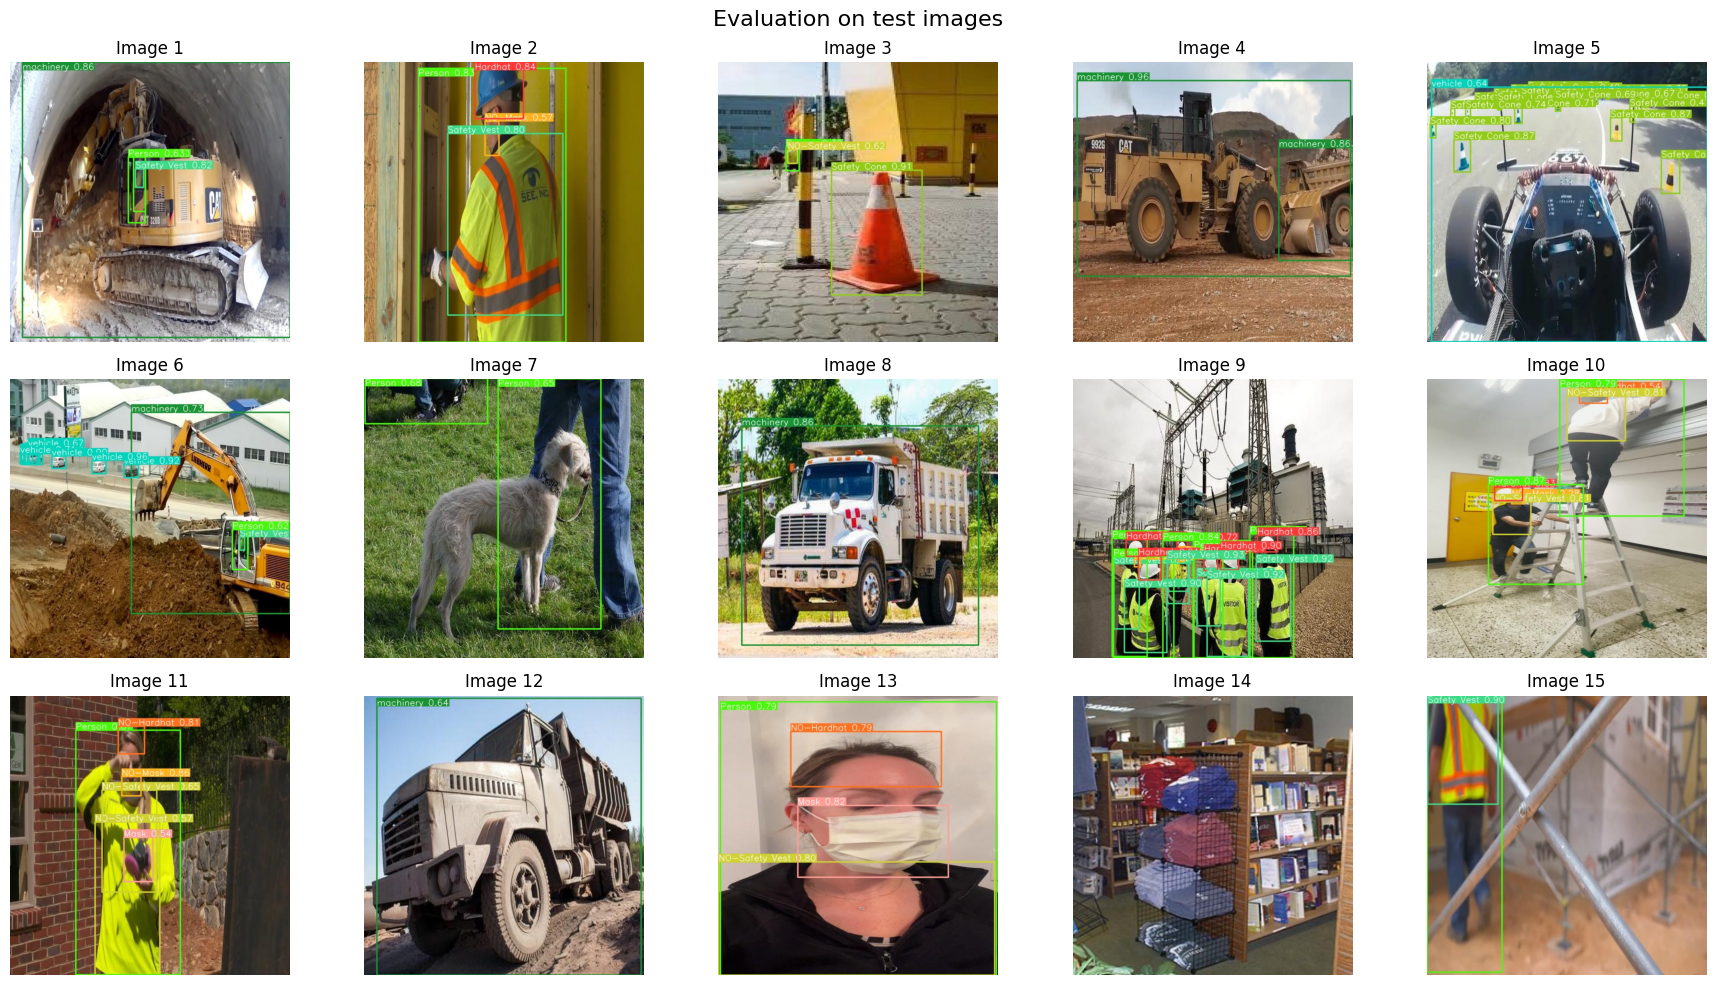

In [27]:
det_res_out_path = '/kaggle/working/runs/detect/predict'

test_imgs_with_pred = glob.glob(os.path.join(det_res_out_path,'*.jpg'))

fig, axes = plt.subplots(3, 5, figsize=(18, 10))
fig.suptitle('Evaluation on test images', fontsize=16)

# Randomly select 15 images
selected_images = random.sample(test_imgs_with_pred, 82)

for i, ax in enumerate(axes.flatten()):
    image = cv2.imread(selected_images[i])
    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

In [28]:
import os
import cv2
import random
import glob
import pandas as pd
import matplotlib.pyplot as plt

# Path to the detection results
det_res_out_path = '/kaggle/working/runs/detect/predict'

# List to store detection results for each image
detection_results = []

# Define class names
class_names = ['Safety helmet', 'Mask', 'Without safety helmet', 'Without mask', 'Without safety vest',
               'Person', 'Safety cone', 'Safety vest', 'Machinery', 'Vehicle']

# Randomly select 15 images
selected_images = random.sample(glob.glob(os.path.join(det_res_out_path, '*.jpg')), 15)

for image_path in selected_images:
    # Assuming you have a function to perform detection and get the results
    # Modify the detection function based on your model and requirements
    results = perform_detection(image_path, class_names)
    
    # Add the image path to the results for reference
    results['image_path'] = image_path
    
    detection_results.append(results)

# Create a DataFrame from the list of detection results
columns = ['image_path'] + class_names + ['binary_result']
df = pd.DataFrame(columns=columns)

# Fill the DataFrame with the detection results
for result in detection_results:
    image_path = result['image_path']
    
    # Add binary results based on your criteria
    binary_result = 1 if any(result[class_name] == 1 for class_name in class_names) else 0
    
    # Add the results to the DataFrame
    df = df.append({'image_path': image_path, **result, 'binary_result': binary_result}, ignore_index=True)

# Save the DataFrame to a CSV file
df.to_csv('/kaggle/working/detection_results.csv', index=False)

# Display the selected images
fig, axes = plt.subplots(3, 5, figsize=(18, 10))
fig.suptitle('Evaluation on test images', fontsize=16)

for i, ax in enumerate(axes.flatten()):
    image = cv2.imread(selected_images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()


NameError: name 'perform_detection' is not defined

In [ ]:
test_data=[]
def create_test_data():
            for j in test:
                if j not in negative:
                    img=cv2.imread(os.path.join(images,j[0]),cv2.IMREAD_GRAYSCALE)
                    img=img[j[1][1]:j[1][1]+j[1][3],j[1][0]:j[1][0]+j[1][2]]
                    new_img=cv2.resize(img,(50,50))
                    new_img=new_img.reshape(-1,50,50,1)
                    predict=model.predict(new_img)
                    test_data.append([j,predict])

create_test_data()

In [29]:
import os
import cv2
import random
import glob
import pandas as pd
import matplotlib.pyplot as plt

# Path to the detection results CSV file
detection_results_path = '/kaggle/working/detection_results.csv'

# Load detection results from the CSV file
detection_results = pd.read_csv(detection_results_path)

fig, axes = plt.subplots(3, 5, figsize=(18, 10))
fig.suptitle('Evaluation on test images with Detection Results', fontsize=16)

# Randomly select 15 images
selected_images = random.sample(test_imgs_with_pred, 82)

for i, ax in enumerate(axes.flatten()):
    image_path = selected_images[i]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Display the image
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"Image {i+1}")
    
    # Find the corresponding row in the detection results DataFrame
    result_row = detection_results[detection_results['image_path'] == image_path].iloc[0]
    
    # Display detection results as text
    detection_text = f"Detection: {' '.join([f'{class_name}: {result_row[class_name]}' for class_name in class_names])}"
    ax.text(0.5, -0.15, detection_text, ha='center', va='center', transform=ax.transAxes, color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.8))

plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout to avoid title overlap
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/detection_results.csv'

<span style="font-size:18px;"> After evaluating the object detector, it's observed that the bounding boxes are generally well-aligned with detected objects and in most cases the bounding boxes exhibit high confidence scores, indicating robust detections. However, there are a few instances with lower confidence scores, suggesting potential uncertainty. In conclusion, the object detector performs reasonably well on the test set. Further fine-tuning or experimenting with different models could potentially improve performance in challenging examples.

# Object tracking 🔍

<span style="font-size:18px;"> Yolov8 also offers the option for object tracking, with two implemented algorithms, BoT-SORT and ByteTrack. In this notebook we will use ByteTrack.
    We will run tracking on a video provided by this dataset.

In [21]:
save_dir = '/kaggle/working/runs/tracking'

In [24]:
p='/kaggle/working/runs/tracking'
p

'/kaggle/working/runs/tracking'

In [26]:
import pandas as pd
a=pd.read_csv('/kaggle/working/runs/detect/Initial training with yolov8/results.csv')
a

epoch        train/box_loss        train/cls_loss  \
0                      1               1.39780               3.00040   
1                      2               1.28790               1.85740   
2                      3               1.24830               1.66110   
3                      4               1.21420               1.56640   
4                      5               1.19230               1.46380   
5                      6               1.16440               1.38940   
6                      7               1.15740               1.36170   
7                      8               1.12710               1.31320   
8                      9               1.12350               1.26540   
9                     10               1.09780               1.22550   
10                    11               1.09860               1.20340   
11                    12               1.07590               1.16430   
12                    13               1.06700               1.13060   
13                    14               1.06780               1.11630   
14                    15               1.04100               1.09760   
15                    16               1.05170               1.08160   
16                    17               1.02950               1.04460   
17                    18               1.01900               1.03090   
18                    19               1.01390               1.01790   
19                    20               1.00450               0.99850   
20                    21               0.99738               0.97924   
21                    22               0.98273               0.95978   
22                    23               0.97386               0.95104   
23                    24               0.97850               0.94383   
24                    25               0.95269               0.92363   
25                    26               0.95371               0.90264   
26                    27               0.95597               0.90033   
27                    28               0.93622               0.87658   
28                    29               0.92586               0.86519   
29                    30               0.92478               0.85430   
30                    31               0.95802               0.80798   
31                    32               0.92380               0.76172   
32                    33               0.91258               0.74045   
33                    34               0.90349               0.72684   
34                    35               0.89626               0.72091   
35                    36               0.88988               0.71340   
36                    37               0.87573               0.70074   
37                    38               0.86740               0.69449   
38                    39               0.85786               0.68155   
39                    40               0.84906               0.67094   

          train/dfl_loss  metrics/precision(B)     metrics/recall(B)  \
0                 1.4950               0.43373               0.33239   
1                 1.4404               0.60766               0.46597   
2                 1.4097               0.67376               0.36268   
3                 1.3804               0.60263               0.47229   
4                 1.3533               0.66971               0.49687   
5                 1.3328               0.63685               0.47324   
6                 1.3269               0.69231               0.49351   
7                 1.3040               0.68535               0.54046   
8                 1.2883               0.72754               0.53638   
9                 1.2809               0.68761               0.58126   
10                1.2769               0.78007               0.56665   
11                1.2619               0.80109               0.56322   
12                1.2484               0.80635               0.59215   
13                1.2421               0.82230            